# Задача прогнозирования визитов клиентов

Дьяконов А.Г., 2023

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [1]:
import numpy as np
import pandas as pd
import time

%pylab inline
#plt.style.use('seaborn-dark')
#import warnings
#warnings.filterwarnings("ignore")
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

import seaborn as sns
%matplotlib inline

%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


## загрузка данных

In [2]:
%%time
df = pd.read_csv('shop_training.csv', parse_dates=['visit_date'])

# r'/content/drive/My Drive/Colab Notebooks/ПЗАД/training.csv'

CPU times: user 4.9 s, sys: 1.47 s, total: 6.37 s
Wall time: 6.91 s


In [7]:
df.head(5)

,customer_id,visit_date,visit_spend
0,2,2010-04-01,5.97
1,2,2010-04-06,12.71
2,2,2010-04-07,34.52
3,2,2010-04-12,7.89
4,2,2010-04-14,17.17


In [8]:
# Уникальных клиентов 100000
print(f"Количество уникальных клиентов: {df['customer_id'].nunique()}")
print(f"Диапозон дней: {(df['visit_date'].max() - df['visit_date'].min()).days + 1}")
print(f"Максимальная дата: {df['visit_date'].max()}")

Количество уникальных клиентов: 100000
Диапозон дней: 445
Максимальная дата: 2011-06-19 00:00:00


## общие траты

In [9]:
spend_on_date_over_all = df.groupby(['visit_date'])['visit_spend'].sum().sort_index()
spend_on_date_over_all.head()

visit_date
2010-04-01    1674538.76
2010-04-02    1528295.25
2010-04-03    1418621.91
2010-04-04     148604.88
2010-04-05     832176.83
Name: visit_spend, dtype: float64

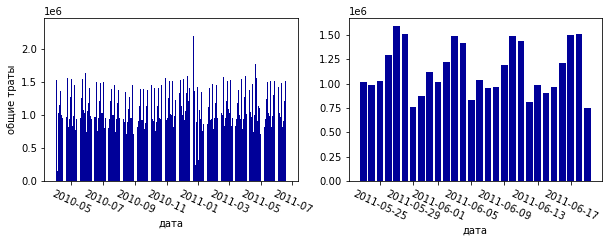

In [14]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.bar(spend_on_date_over_all.index, spend_on_date_over_all, color='#000099');
plt.xticks(rotation=-25);
plt.xlabel('дата')
plt.ylabel('общие траты')

plt.subplot(122)
plt.bar(spend_on_date_over_all[-28:].index, spend_on_date_over_all[-28:], color='#000099');
plt.xticks(rotation=-25);
plt.xlabel('дата');

In [15]:
# общие траты
spends = df.visit_spend.values
spends = spends[spends < 250]

Text(0, 0.5, 'значение гистограммы')

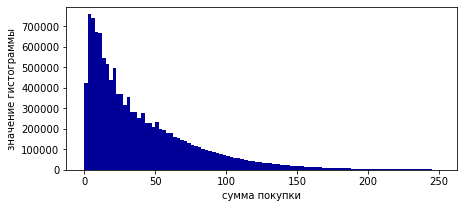

In [16]:
plt.figure(figsize=(7, 3))
plt.hist(spends, bins=100, color='#000099');
plt.xlabel('сумма покупки')
plt.ylabel('значение гистограммы')

## траты по дням

In [20]:
%%time
df['weekday'] = df.visit_date.dt.weekday

CPU times: user 978 ms, sys: 16.8 ms, total: 995 ms
Wall time: 1.12 s


In [22]:
visits_on_weekday = df.groupby(['weekday'])['visit_spend'].count() #.sort_index()
visits_on_weekday

weekday
0    1669166
1    1699740
2    1699473
3    1879063
4    2035634
5    1916671
6    1246890
Name: visit_spend, dtype: int64

Text(0, 0.5, 'вероятность прихода')

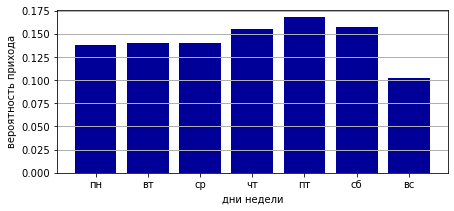

In [24]:
plt.figure(figsize=(7, 3))
plt.bar(visits_on_weekday.index, visits_on_weekday.values / df.shape[0], color='#000099')
plt.xticks(visits_on_weekday.index, ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']);
plt.grid(axis='y', lw=1)
plt.xlabel('дни недели')
plt.ylabel('вероятность прихода')

### необязательная проверка на отсортированность по дате данных клиента

In [46]:
%%time
df.groupby('customer_id')['visit_date'].apply(lambda x: all(x.sort_values().values == x.values)).all()

True

In [54]:
# проверка на дубликаты
df.duplicated(subset=['customer_id',
                      'visit_date']).sum()

0

### Данные одного клиента

In [25]:
random_customer = np.random.choice(df['customer_id'].unique())
print (f'клиент = {random_customer}')

random_customer_spend = df[df['customer_id'] == random_customer]
random_customer_spend.head()


клиент = 131641


,customer_id,visit_date,visit_spend,weekday
10708421,131641,2010-04-03,10.84,5
10708422,131641,2010-04-25,81.06,6
10708423,131641,2010-05-03,13.47,0
10708424,131641,2010-05-29,91.63,5
10708425,131641,2010-06-05,43.56,5


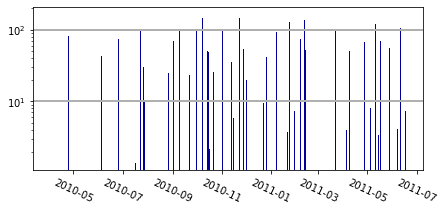

In [26]:
plt.figure(figsize=(7, 3))

plt.bar(random_customer_spend['visit_date'],
        random_customer_spend['visit_spend'], color='#000099')
plt.xticks(rotation=-25);
plt.yscale('log')
plt.grid(axis='y', lw=2)

In [27]:
%%time
df['weekofyear'] = df.visit_date.dt.weekofyear # df.visit_date.dt.isocalendar().week
df['year'] = df.visit_date.dt.year

/home/dash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


CPU times: user 2.16 s, sys: 357 ms, total: 2.52 s
Wall time: 2.65 s


In [31]:
random_customer_spend = df[df['customer_id'] == random_customer]

In [32]:
random_customer_spend_pivot = random_customer_spend.pivot_table(index=['year', 'weekofyear'],
                                                                columns='weekday',
                                                                values='visit_spend')

In [33]:
random_customer_spend_pivot.head()

weekday              0   1   2   3   4      5      6
year weekofyear                                     
2010 13            NaN NaN NaN NaN NaN  10.84    NaN
     16            NaN NaN NaN NaN NaN    NaN  81.06
     18          13.47 NaN NaN NaN NaN    NaN    NaN
     21            NaN NaN NaN NaN NaN  91.63    NaN
     22            NaN NaN NaN NaN NaN  43.56    NaN

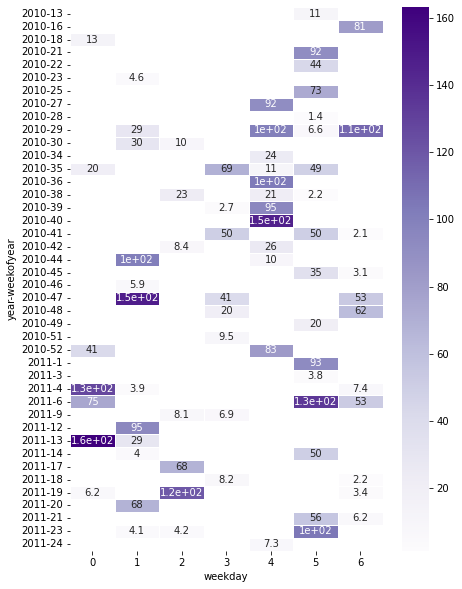

In [34]:
plt.figure(figsize=(7, 10))
sns.heatmap(random_customer_spend_pivot, annot=True,
            linewidths=.5, cmap='Purples');

## Моделируем соревнование

In [35]:
df['day_of_year'] = df.visit_date.dt.day_of_year

In [36]:
df.year.unique(), df.day_of_year.unique()

(array([2010, 2011]),
 array([ 91,  96,  97, 102, 104, 106, 109, 119, 120, 127, 131, 133, 134,
        138, 139, 141, 144, 145, 151, 166, 171, 176, 177, 183, 184, 189,
        190, 208, 209, 211, 218, 223, 224, 228, 238, 239, 243, 249, 250,
        256, 259, 260, 261, 263, 264, 267, 271, 272, 273, 274, 279, 281,
        286, 294, 295, 302, 303, 309, 316, 319, 320, 324, 325, 326, 334,
        335, 337, 338, 341, 343, 344, 346, 351, 357, 358, 365,   2,   4,
          7,  13,  15,  21,  22,  25,  27,  28,  34,  36,  42,  46,  49,
         50,  55,  57,  60,  61,  63,  78,  79,  84,  88,  90,  92,  98,
         99, 103, 105, 108, 110, 116, 117, 123, 146, 148, 150, 159, 161,
        163, 164, 170,  93, 100, 107, 112, 114, 118, 121, 126, 128, 132,
        135, 140, 142, 147, 154, 155, 162, 168, 169, 191, 196, 198, 203,
        205, 212, 215, 219, 226, 231, 233, 237, 240, 241, 247, 253, 254,
        266, 268, 275, 276, 282, 283, 285, 289, 290, 291, 296, 297, 301,
        306, 307, 310, 317, 3

In [40]:
df['day'] = (df.year - 2010)*365 + (df.day_of_year - 1)

In [41]:
df.customer_id.unique()

array([     2,      3,      4, ..., 149198, 149199, 149200])

In [42]:
df.head()

,customer_id,visit_date,visit_spend,weekday,weekofyear,year,day_of_year,day
0,2,2010-04-01,5.97,3,13,2010,91,90
1,2,2010-04-06,12.71,1,14,2010,96,95
2,2,2010-04-07,34.52,2,14,2010,97,96
3,2,2010-04-12,7.89,0,15,2010,102,101
4,2,2010-04-14,17.17,2,15,2010,104,103


In [43]:
from scipy.sparse import csc_matrix
#csc_matrix
#csc_array

M = csc_matrix((df.visit_spend.values,
               (df.customer_id.values, df.day.values)),
              shape=(df.customer_id.max()+1, df.day.max()+1))

In [44]:
M.shape

(149201, 535)

In [46]:
# здесь ij-й элемент = траты i-го клиента в j-й день
M.todense()

matrix([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , 41.  ],
        ...,
        [ 0.  ,  0.  ,  0.  , ..., 56.08,  0.  , 75.42],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ..., 22.44, 11.64,  0.  ]])

In [47]:
# выкинем лишние строки

I = M[:,-7:].sum(axis=1)>0
I = np.array(I)[:,0]
M = M[I,:]
M.shape

(84941, 535)

### Делаем обучении и контроль

In [48]:
M_train = np.array(M[:, 3:-7].todense()) # чтобы делилось на 7
M_test = np.array(M[:, -7:].todense())

print (M_train.shape, M_test.shape)

(84941, 525) (84941, 7)


In [49]:
M_test

array([[ 29.38,   0.  ,   0.  , ...,   0.  ,   0.  ,  41.  ],
       [  0.  ,   0.  ,   7.97, ...,   0.  ,  54.91,   0.  ],
       [  0.  ,   0.  , 129.57, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,  56.08,   0.  ,  75.42],
       [  0.  ,   0.  ,  88.69, ...,   0.  ,   0.  ,   0.  ],
       [  3.44,  20.99,   0.  , ...,  22.44,  11.64,   0.  ]])

In [50]:
#  вектор, содержащий ответы
y_test = (M_test>0).argmax(axis=1)
y_test

array([0, 2, 2, ..., 4, 2, 0])

## Ответ "как последняя неделя"

In [53]:
a = (M_train[:,-7:] > 0).argmax(axis=1)
e_last = np.mean(y_test == a)
print (f"качество = {e_last:.3}")

качество = 0.345


## Ответ "как предпоследняя неделя"

In [54]:
a = (M_train[:,-14:-7] > 0).argmax(axis=1)
e_prelast = np.mean(y_test == a)
print (f"качество = {e_prelast:.3}")

качество = 0.299


## Ответ "понедельник"

In [55]:
e_monday = np.mean(y_test == 0)
print (f"качество = {e_monday:.3}")

качество = 0.313


## Ответ через вероятности

In [56]:
m = M_train.shape[0]
print(f"клиентов = {m}")

клиентов = 84941


по максимальной вероятности

In [57]:
tmp = M_train.reshape(m, 75, 7)
tmp = (tmp > 0).mean(axis=1)
# tmp = tmp[:, -1,:] > 0 # так был бы последняя неделя
a = tmp.argmax(axis=1)
e_p1 = np.mean(y_test == a)
print (f"качество = {e_p1:.3}")

качество = 0.282


а теперь уже правильно с пересчётом

In [58]:
tmp = M_train.reshape(m, 75, 7)
tmp = (tmp > 0).mean(axis=1)

tmp[:,1:] = tmp[:,1:] * (1 - tmp[:,:-1]).cumprod(axis=1)

a = tmp.argmax(axis=1)
e_p2 = np.mean(y_test == a)
print (f"качество = {e_p2:.3}")

качество = 0.421


## весовая схема

In [59]:
k = 75
ws = np.arange(1, k+1) ** 2
ws = ws / np.sum(ws)

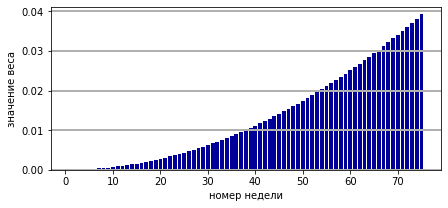

In [60]:
plt.figure(figsize=(7, 3))
plt.bar(np.arange(1, k+1), ws, color='#000099')
plt.ylabel('значение веса')
plt.xlabel('номер недели');
plt.grid(axis='y',lw=2)

In [61]:
tmp = M_train.reshape(m, 75, 7)
tmp = tmp > 0
sumtmp = 0.0
for t, w in enumerate(ws):
    sumtmp += w*tmp[:, t, :]
    
sumtmp[:,1:] = sumtmp[:,1:] * (1 - sumtmp[:,:-1]).cumprod(axis=1)

a = sumtmp.argmax(axis=1)
e_w = np.mean(y_test == a)
print (f"качество = {e_w:.3}")

качество = 0.428


## исследование весовых схем

In [62]:
degrees = np.linspace(0, 10, 101)
es = []

for d in degrees:
    ws = np.arange(1, k+1) ** d
    ws = ws / np.sum(ws)
    
    tmp = M_train.reshape(m, 75, 7)
    tmp = tmp > 0
    sumtmp = 0.0
    for t, w in enumerate(ws):
        sumtmp += w*tmp[:, t, :]
        
    sumtmp[:,1:] = sumtmp[:,1:] * (1 - sumtmp[:,:-1]).cumprod(axis=1)        
    
    a = sumtmp.argmax(axis=1)
    e = np.mean(y_test == a)
    
    es.append(e)    

(0.0, 10.0)

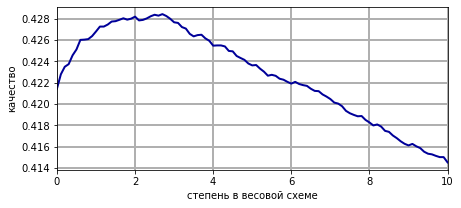

In [63]:
plt.figure(figsize=(7, 3))
plt.plot(degrees, es, c='#000099', lw=2)
plt.xlabel('степень в весовой схеме')
plt.ylabel('качество')
plt.grid(lw=2)
plt.xlim([0, 10])

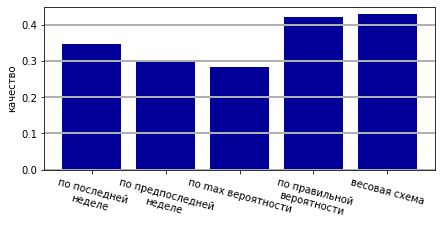

In [64]:
plt.figure(figsize=(7, 3))
plt.bar([1,2,3,4,5], [e_last, e_prelast, e_p1, e_p2, e_w], color='#000099')
plt.xticks([1,2,3,4,5], ['по последней\nнеделе', 'по предпоследней\nнеделе',
                         'по max вероятности', 'по правильной\nвероятности',
                        'весовая схема'], rotation=-15)
plt.ylabel('качество')
plt.grid(axis='y',lw=2)

## Ансамбли